## Carga del dataset

In [1]:
import pandas as pd
import numpy as np
import os, sys, shutil

# Load preprocessed data

# Load original state data

In [2]:
!wget https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
!unzip -o -q data_downscaled
!mv .tmp original

--2020-11-23 15:47:41--  https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990385145 (945M) [application/zip]
Saving to: ‘data_downscaled.zip’

data_downscaled.zip 100%[===================>] 944.50M  66.2MB/s    in 16s     

2020-11-23 15:47:59 (60.7 MB/s) - ‘data_downscaled.zip’ saved [990385145/990385145]



In [3]:
!mkdir data
!mkdir data/original

In [4]:
!mv /content/original/raw_dataset_extracted_downscaled /content/data/original

In [5]:
!mkdir /content/data/dataframes && mv /content/data/original/raw_dataset_extracted_downscaled/trainLabels.csv /content/data/dataframes

In [134]:
labels = pd.read_csv('data/dataframes/trainLabels.csv')
valuesWithE = labels.loc[labels['level'] >= 1]
valuesNeutral = labels.loc[labels['level'] == 0]

print(len(valuesNeutral))
print(len(valuesWithE))

sampledNeutral = valuesNeutral.sample(len(valuesWithE), random_state=44)
print(len(sampledNeutral))

sampled = pd.concat([valuesWithE, sampledNeutral])
sampled = sampled.sample(frac=1).reset_index(drop=True)
print(len(sampled))

25810
9316
9316
18632


In [39]:
sampled

,Unnamed: 0,image,level,ancho,alto,Diabetes
0,12221,15336_right,0,4272,2848,No
1,3995,5013_right,0,3888,2592,No
2,7705,9693_right,0,4752,3168,No
3,3640,4551_left,0,4752,3168,No
4,559,681_right,2,4752,3168,Si
...,...,...,...,...,...,...
18627,32158,40612_left,2,4288,2848,Si
18628,16879,21172_right,1,3504,2336,Si
18629,32364,40871_left,0,4272,2848,No
18630,21385,26939_right,0,3888,2592,No


In [40]:
!rm -rf resampled
!mkdir resampled
!mkdir resampled/original
!mkdir resampled/preprocessed

In [41]:
def create_directory_flow(df, subset_name, base, dest, imageType):
  k = 0
  for _, row in df.iterrows():
    item = row.image
    level = row['level']
    basedir = base
    destDir = dest
    ext = '.jpeg'
    k = k+1
    orig_file = os.path.join(basedir, item + ext)
    if level == 0:
      os.makedirs(os.path.join(destDir, subset_name, 'No DR'), exist_ok=True)
      dest_file = os.path.join(destDir, subset_name, 'No DR', item +str(k) + ext)
      shutil.copy(orig_file, dest_file)
    else:
      os.makedirs(os.path.join(destDir, subset_name, 'DR'), exist_ok=True)
      dest_file = os.path.join(destDir, subset_name, 'DR', item +str(k) + ext)
      shutil.copy(orig_file, dest_file)

In [42]:
# Copy resampled original
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
train, test = train_test_split(sampled, train_size = 0.8, random_state=44, stratify=sampled.level)
test, val = train_test_split(test, test_size=0.5, random_state=44, stratify=test.level)

create_directory_flow(train,
                      'train',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

create_directory_flow(val,
                      'validation',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

create_directory_flow(test,
                      'test',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

In [237]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

import cv2

img_shape = (224, 224)
train_path = os.path.join('/content/resampled', 'original', 'train')
validation_path = os.path.join('/content/resampled','original', 'validation')
test_path = os.path.join('/content/resampled','original', 'test')

# Reescalamos todas las imágenes en un factor de 1./255
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# La función flow_from_directory() toma el path a un directorio
# y genera batches de data a la que aplica las transformaciones definidas
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_shape,
        batch_size=128,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_path,
        target_size=img_shape,
        batch_size=128,
        shuffle=False,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_shape,
        batch_size=128,
        shuffle=False,
        class_mode='binary')

Found 14905 images belonging to 2 classes.
Found 1864 images belonging to 2 classes.
Found 1863 images belonging to 2 classes.


In [238]:
train_generator.class_indices

{'DR': 0, 'No DR': 1}

In [239]:
len(train_generator.classes)

14905

In [240]:
def attention(bn, pt_depth):
  attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn)
  attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
  attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
  up_c2.trainable = False
  attn_layer = up_c2(attn_layer)
  mask_features = multiply([attn_layer, bn])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn_layer)
  return Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])


In [252]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization, LocallyConnected2D
from tensorflow.keras.layers import Flatten, Input, Conv2D, multiply
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Lambda, GlobalMaxPooling2D, Concatenate, MaxPooling2D

(w, h) = img_shape
input_shape = [w, h, 3]

input_layer = Input(input_shape)
inception = InceptionV3(input_shape=input_shape,
                                          include_top = False,
                                          weights='imagenet')

inception.trainable = False
x = inception(input_layer)

x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(x)
x = Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
pt_features = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

pt_features1 = GlobalAveragePooling2D()(pt_features)
pt_features2 = GlobalMaxPooling2D()(pt_features)
pt_features3 = attention(pt_features, 64)

pt_features = Concatenate()([pt_features1, pt_features2, pt_features3])

pt_features = Dense(64, activation = "relu")(pt_features)
classification_layer = Dense(1, activation = "sigmoid")(pt_features)

retina_model = Model(inputs=[input_layer], outputs=[classification_layer])


In [253]:
retina_model.summary()

Model: "functional_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 5, 5, 2048)   21802784    input_103[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 5, 5, 64)     1179712     inception_v3[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 5, 5, 64)     36928       block1_conv1[0][0]               
______________________________________________________________________________________

In [254]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)

retina_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [255]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

In [256]:
history = retina_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=130,
    callbacks=[reduceLROnPlat, early_stopping],
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

Epoch 1/130
117/117 [==============================] - 61s 520ms/step - loss: 0.7130 - accuracy: 0.6363 - val_loss: 0.5798 - val_accuracy: 0.7006
Epoch 2/130
117/117 [==============================] - 59s 504ms/step - loss: 0.5747 - accuracy: 0.6957 - val_loss: 0.5805 - val_accuracy: 0.6744
Epoch 3/130
117/117 [==============================] - 59s 508ms/step - loss: 0.5464 - accuracy: 0.7129 - val_loss: 0.5596 - val_accuracy: 0.7141
Epoch 4/130
117/117 [==============================] - 59s 507ms/step - loss: 0.5336 - accuracy: 0.7234 - val_loss: 0.5485 - val_accuracy: 0.7189
Epoch 5/130
117/117 [==============================] - 59s 507ms/step - loss: 0.5257 - accuracy: 0.7319 - val_loss: 0.5425 - val_accuracy: 0.7253
Epoch 6/130
117/117 [==============================] - 59s 503ms/step - loss: 0.5191 - accuracy: 0.7334 - val_loss: 0.5842 - val_accuracy: 0.7103
Epoch 7/130
117/117 [==============================] - 59s 504ms/step - loss: 0.5126 - accuracy: 0.7377 - val_loss: 0.5432 -

In [257]:
def predictAndEvaluate(model_):
  y_pred = model_.predict(test_generator,steps=100)
  from sklearn.metrics import classification_report
  y_pred1 =y_pred.copy()
  y_pred1[y_pred1>=0.5] = 1
  y_pred1[y_pred1<0.5] = 0
  y_pred1=y_pred1.astype(int)

  print(classification_report(test_generator.classes, y_pred1))
  from sklearn.metrics import balanced_accuracy_score
  print(balanced_accuracy_score(test_generator.classes, y_pred1))

In [258]:
predictAndEvaluate(retina_model)

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       932
           1       0.70      0.83      0.76       931

    accuracy                           0.74      1863
   macro avg       0.75      0.74      0.74      1863
weighted avg       0.75      0.74      0.74      1863

0.7381040737957709


In [261]:
import matplotlib.pyplot as plt
def plotHistory(history_):
  plt.plot(history_.history['accuracy'])
  plt.plot(history_.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history_.history['loss'])
  plt.plot(history_.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

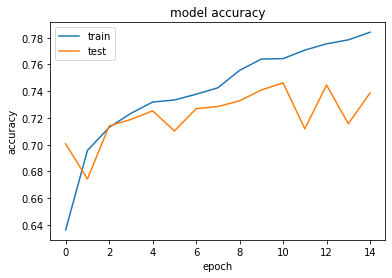

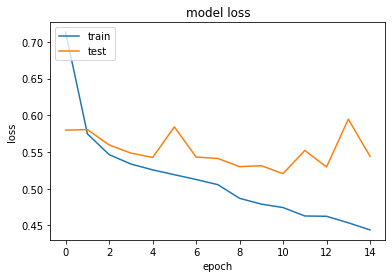

In [262]:
plotHistory(history)

In [263]:
for layer in inception.layers[:249]:
    layer.trainable = False
for layer in inception.layers[249:]:
    layer.trainable = True

In [264]:
import tensorflow as tf
retina_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.0001, momentum=0.9),
    metrics=['accuracy']
)

In [ ]:
history2 = retina_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
     callbacks=[reduceLROnPlat, early_stopping],
  )